<a href="https://colab.research.google.com/github/hmsch/porcelan/blob/main/data/tumor_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [2]:
!wget 'https://zenodo.org/records/5847462/files/KPTracer-Data.tar.gz?download=1' -O data/KPTracer-Data.tar.gz
!tar -xvzf data/KPTracer-Data.tar.gz -C data/
!rm data/KPTracer-Data.tar.gz

--2024-10-08 12:32:36--  https://zenodo.org/records/5847462/files/KPTracer-Data.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1304975216 (1.2G) [application/octet-stream]
Saving to: ‘data/KPTracer-Data.tar.gz’

data/KPTracer-Data. 100%[===================>]   1.21G  35.0MB/s    in 37s     

2024-10-08 12:33:13 (34.0 MB/s) - ‘data/KPTracer-Data.tar.gz’ saved [1304975216/1304975216]

KPTracer-Data/
KPTracer-Data/plasticity_scores.tsv
KPTracer-Data/._.DS_Store
KPTracer-Data/.DS_Store
KPTracer-Data/trees/
KPTracer-Data/._trcr_master.txt
KPTracer-Data/trcr_master.txt
KPTracer-Data/._README
KPTracer-Data/README
KPTracer-Data/fitnesses/
KPTracer-Data/KPTracer.alleleTable.unfiltered.txt
KPTracer-Data/KPTracer.alleleTable.FINAL.txt
KPTracer-Data/expression/
KPTracer-Data/expansions/
KPTracer-Data/tumor_statis

# Imports & read data

In [1]:
import pandas as pd
import numpy as np
import dendropy
import scanpy
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

from tree_util import get_apn_dist_triplet_lut, dist_matrix_to_numpy

data_path = './data'
meta_df = pd.read_csv(f'{data_path}/KPTracer-Data/KPTracer_meta.csv')
meta_df

,Unnamed: 0,TS_Present,RNA_Present,MULTI,TS_UMI,NUM_INTBC,Lane,Tumor,SubTumor,ES_clone,...,Mouse,Aging_Month,Batch_Library,Batch_Harvest,Aging_Time,MetFamily,lentiBC,is_normal,PercentUncut,annotated_normal_rna
0,L10.AAACCTGAGACGCAAC-1,True,True,ATCTCGGA,522.0,9.0,L10,3724_NT_T1,3724_NT_T1_14,2E1,...,3724,6.0,2.0,2_1,184.0,3724_NT_T1,Negative,False,0.074074,False
1,L10.AAACCTGAGAGTTGGC-1,True,True,ATCTCGGA,346.0,9.0,L10,3724_NT_T1,3724_NT_T1_14,2E1,...,3724,6.0,2.0,2_1,184.0,3724_NT_T1,Negative,False,0.074074,False
2,L10.AAACCTGAGCTCCTCT-1,True,True,GTCAATCG,349.0,9.0,L10,3724_NT_T1,3724_NT_T1_11,2E1,...,3724,6.0,2.0,2_1,184.0,3724_NT_T1,Negative,False,0.074074,False
3,L10.AAACCTGAGGCAGGTT-1,True,True,GCCCCGAA,512.0,9.0,L10,3724_NT_T1,3724_NT_T1_12,2E1,...,3724,6.0,2.0,2_1,184.0,3724_NT_T1,Negative,False,0.074074,False
4,L10.AAACCTGAGTACACCT-1,True,True,ATCTCGGA,274.0,9.0,L10,3724_NT_T1,3724_NT_T1_14,2E1,...,3724,6.0,2.0,2_1,184.0,3724_NT_T1,Negative,False,0.074074,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106679,L33.TTGAACGTCCTCAATT-1,False,True,GGCCGGTT,0.0,0.0,L33,None,None,2E1,...,3513,6.0,6.0,6_1,181.0,None,Negative,False,NaN,True
106680,L33.TTGAACGTCTGCTGTC-1,False,True,GGCCGGTT,0.0,0.0,L33,None,None,2E1,...,3513,6.0,6.0,6_1,181.0,None,GGGCATTAGTCCGCGT,False,NaN,True
106681,L33.TTGGAACAGTGGTAGC-1,False,True,GGCCGGTT,0.0,0.0,L33,None,None,2E1,...,3513,6.0,6.0,6_1,181.0,None,Negative,False,NaN,True
106682,L33.TTGGCAAAGTATCGAA-1,False,True,GGCCGGTT,0.0,0.0,L33,None,None,2E1,...,3513,6.0,6.0,6_1,181.0,None,None,False,NaN,True


In [2]:
adata = scanpy.read_h5ad(f'{data_path}/KPTracer-Data/expression/adata_processed.combined.h5ad')
adata

AnnData object with n_obs × n_vars = 104197 × 4000
    obs: 'TS_Present', 'RNA_Present', 'MULTI', 'TS_UMI', 'NUM_INTBC', 'Lane', 'Tumor', 'SubTumor', 'ES_clone', 'genotype', 'Aging_time', 'Mouse', 'Aging_Month', 'Batch_Library', 'Batch_Harvest', 'Aging_Time', 'MetFamily', 'lentiBC', 'LentiFiltered', 'is_normal', 'PercentUncut', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Cluster', 'Cluster-Name'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_Library_colors', 'C_scANVI_colors', 'Cluster-Name_colors', 'Cluster_colors', 'Combined_Clusters_colors', 'Mouse_colors', 'NT_leiden_colors', '_scvi', 'genotype_colors', 'hvg', 'leiden', 'leiden_0.2_colors', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_0.8_colors', 'leiden_1.0_colors', 'leiden_1.5_colors', 'neighbors', 'umap

# Tumor 3435_NT_T1

In [2]:
name = '3435_NT_T1'

## Prune tree

In [4]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 21.0


In [5]:
tumor_meta = meta_df[(meta_df['Tumor'] == name) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'] == name]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [6]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

1124 1149 1438
meta but not tree (vice versa):  25 ( 0 )
tree but not adata (vice versa):  12 ( 326 )
meta but not adata (vice versa):  37 ( 326 )
intersection:  1112


In [7]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 17.0
leaves: 1112


In [8]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 17]),
 array([1112,  624,   98,   27,   14,    5,    3,    2,    4,    2,    2,
           1,    1]))

## Gene expression pre-processing

In [9]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(1112, 4000)
genes expressed in 10 or more cells: 714
(1112, 714)


In [10]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

In [11]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

### Highly variable genes

values to clip: 0


/tmp/ipykernel_3893707/4156051735.py:14: RuntimeWarning: invalid value encountered in sqrt
  adj_gene_counts = (gene_counts - gene_counts.mean(axis=0)) / np.sqrt(gene_stats['pred var'].values)
/tmp/ipykernel_3893707/4156051735.py:21: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  gene_stats.loc[:100, 'hvg'] = True


,mean,var,pred var,adj. var,hvg
Lyz2,8.351615,1.543824,0.194812,7.924704,True
Clu,8.162143,1.486609,0.232701,6.388487,True
S100a6,6.294310,2.324415,0.622314,3.735116,True
Scgb1a1,5.697284,2.174673,0.758246,2.868028,True
Hp,3.369871,3.487331,1.382725,2.522073,True
...,...,...,...,...,...
Atp5j,4.627385,0.553604,0.995732,0.555977,False
Myl6,5.235381,0.441425,0.864174,0.510805,False
Itm2b,4.700758,0.495406,0.980386,0.505317,False
Sftpc,11.179564,1.179284,-0.361879,NaN,False


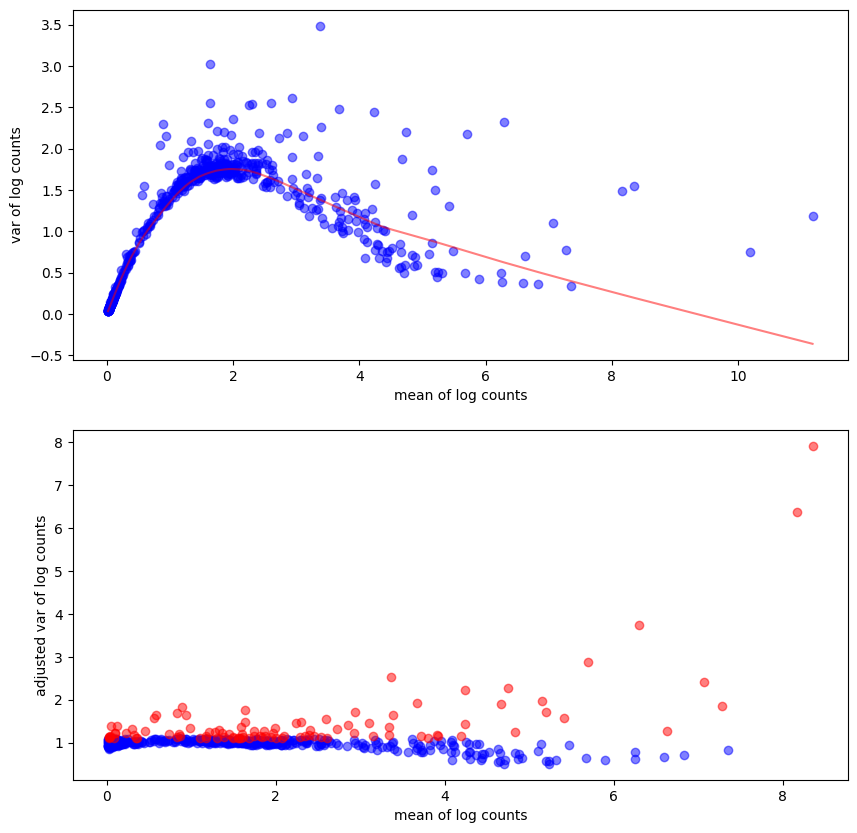

In [12]:
gene_stats = pd.DataFrame()
gene_stats.index = gene_names
gene_stats['mean'] = gene_counts.mean(axis=0)
gene_stats['var'] = gene_counts.var(axis=0)
gene_stats['pred var'] = lowess(gene_stats['var'], gene_stats['mean'], return_sorted=False, frac=1/3)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax.plot(gene_stats['mean'], gene_stats['var'], 'ob', alpha=0.5)
gene_stats_sorted = gene_stats.sort_values('mean')
ax.plot(gene_stats_sorted['mean'], gene_stats_sorted['pred var'], '-r', alpha=0.5)
ax.set_xlabel('mean of log counts')
ax.set_ylabel('var of log counts')

adj_gene_counts = (gene_counts - gene_counts.mean(axis=0)) / np.sqrt(gene_stats['pred var'].values)
print('values to clip:', (np.abs(adj_gene_counts) > np.sqrt(len(gene_counts))).sum())
adj_gene_counts = np.clip(adj_gene_counts, -np.sqrt(len(gene_counts)), np.sqrt(len(gene_counts)))

gene_stats['adj. var'] = adj_gene_counts.var(axis=0)
gene_stats = gene_stats.sort_values('adj. var', ascending=False)
gene_stats['hvg'] = False
gene_stats.loc[:100, 'hvg'] = True

ax2.plot(gene_stats[~gene_stats['hvg']]['mean'], gene_stats[~gene_stats['hvg']]['adj. var'], 'ob', alpha=0.5)
ax2.plot(gene_stats[gene_stats['hvg']]['mean'], gene_stats[gene_stats['hvg']]['adj. var'], 'or', alpha=0.5)
ax2.set_xlabel('mean of log counts')
ax2.set_ylabel('adjusted var of log counts')
fig.show()

gene_stats

In [13]:
hvg_gene_names_inorder = gene_stats[gene_stats['hvg']].index
print('ordered:', hvg_gene_names_inorder)

ordered: Index(['Lyz2', 'Clu', 'S100a6', 'Scgb1a1', 'Hp', 'Actb', 'Krt7', 'Ager',
       'Spp1', 'Cldn18', 'Areg', 'Sftpb', 'Krt20', 'Plac8', 'Krt19', 'Cd24a',
       'Mcpt1', 'Onecut2', 'S100a14', 'Tff1', 'Ly6d', 'Cxcl5', 'Crlf1',
       'Cldn4', 'Tspan1', 'Egfl6', 'Bex4', 'Slc34a2', 'Cited2', 'Dapl1',
       'Cxcl10', 'Btg2', 'Bpifa1', 'Gsr', 'Cox6a2', 'Sox4', 'Stmn2',
       'Hmga1-rs1', 'Id3', 'Krt18', 'Foxq1', 'R3hdml', 'Atp2b1', 'H2-Aa',
       'Serpinb6b', 'Ugdh', 'Gstp1', 'Klf5', 'Gap43', 'Hist1h2ap', 'Oasl1',
       'Pgk1', 'Il33', 'Myh7', 'Igfbp5', 'Car2', 'Dcpp1', 'Lmna', 'Ier5',
       'Lamp3', 'S100a7a', 'Ctsl', 'Elf3', 'Fdx1', 'Tkt', 'Btg1', 'Cdc42ep5',
       'Ctsd', 'Ier2', 'Ifi27', 'Siva1', 'Cct2', 'Pdlim7', 'Cebpb',
       '2610001J05Rik', 'Pgam2', 'Akr1b3', 'Actn1', 'M1ap', 'Eif6', 'Anxa7',
       'Eif1a', 'Srm', 'Myo5a', 'Aurka', 'Epcam', 'Pgd', 'Ywhag', 'Tmbim1',
       'Lsr', 'Il6', 'mt-Nd2', 'Ahnak', 'Klf13', 'Snrpg', 'Slc16a11', 'Eprs',
       'H2afy2', 'Gm9774'

In [14]:
np.savetxt(f'{data_path}/preprocessed/{name}_hvg_genes.txt', hvg_gene_names_inorder, fmt='%s')

## Cell types

In [15]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L30.AAACCTGAGCGTAGTG-1,AT2-like
L30.AAACCTGGTGGTCCGT-1,AT2-like
L30.AAACGGGAGAGTACAT-1,AT2-like
L30.AAACGGGCAATGAAAC-1,AT2-like
L30.AAACGGGCACCGGAAA-1,AT2-like
...,...
L30.TTTGGTTTCTGCGTAA-1,Lung progenitor-like
L30.TTTGTCAAGAAGGTTT-1,AT2-like
L30.TTTGTCAGTCTGGTCG-1,AT1-like


In [16]:
cell_types['Cluster-Name'].value_counts()

AT2-like                   667
Lung progenitor-like       214
AT1-like                   114
High plasticity             67
Gastric-like                17
Pre-EMT                     15
Early EMT-1                 11
Early EMT-2                  3
Endoderm-like                3
Early gastric                1
Mesenchymal-2                0
Mesenchymal-1 (Met)          0
Late Gastric                 0
Mesenchymal-2 (Met)          0
Mesenchymal-1                0
Apc Mesenchymal-1 (Met)      0
Apc Early                    0
Apc Mesenchymal-2            0
Lkb1 subtype                 0
Name: Cluster-Name, dtype: int64

In [17]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)

## Triplet look-up table

In [3]:
tree = dendropy.Tree.get(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  cell_names = np.array(f.read().splitlines())
# computing the phylogenetic_distance_matrix with dendropy can take a few minutes
dist_matrix = dist_matrix_to_numpy(tree.phylogenetic_distance_matrix(), cell_names)
apn_lut = get_apn_dist_triplet_lut(dist_matrix)

with open(f'{data_path}/preprocessed/{name}_apn_pd_triplet_lut.npy', 'wb') as f:
  np.save(f, apn_lut)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:01<00:00, 908.71it/s]


# Tumor 3726_NT_T2

In [19]:
name = '3726_NT_T2'

## Prune tree

In [20]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 19.0


In [21]:
tumor_meta = meta_df[(meta_df['Tumor'] == name) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'] == name]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [22]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

854 855 936
meta but not tree (vice versa):  1 ( 0 )
tree but not adata (vice versa):  1 ( 83 )
meta but not adata (vice versa):  2 ( 83 )
intersection:  853


In [23]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 15.0
leaves: 853


In [24]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([ 0,  2,  3,  4,  5,  7,  8, 11]),
 array([853, 597,  70,  20,   5,   3,   1,   1]))

## Gene expression pre-processing

In [25]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(853, 4000)
genes expressed in 10 or more cells: 689
(853, 689)


In [26]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

In [27]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

## Cell types

In [28]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L6.AAACCTGTCATGTCCC-1,AT2-like
L6.AAACGGGAGATGTCGG-1,AT2-like
L6.AAACGGGCAAGGACAC-1,AT2-like
L6.AAAGATGAGGATCGCA-1,AT2-like
L6.AAAGCAACATGTAGTC-1,AT2-like
...,...
L6.TTTGGTTGTCGAGATG-1,AT2-like
L6.TTTGGTTGTTTGTTTC-1,AT2-like
L6.TTTGTCAGTGTGGTTT-1,AT2-like


In [29]:
cell_types['Cluster-Name'].value_counts()

AT2-like                   755
AT1-like                    58
Early gastric               18
High plasticity             11
Gastric-like                 5
Early EMT-1                  5
Pre-EMT                      1
Late Gastric                 0
Apc Mesenchymal-2            0
Apc Early                    0
Apc Mesenchymal-1 (Met)      0
Early EMT-2                  0
Endoderm-like                0
Mesenchymal-1 (Met)          0
Lung progenitor-like         0
Mesenchymal-2                0
Mesenchymal-2 (Met)          0
Mesenchymal-1                0
Lkb1 subtype                 0
Name: Cluster-Name, dtype: int64

In [30]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)

# Tumor 3730_NT_T1

In [31]:
name = '3730_NT_T1'

## Prune tree

In [32]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 23.0


In [33]:
tumor_meta = meta_df[(meta_df['Tumor'] == name) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'] == name]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [34]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

1226 1234 1301
meta but not tree (vice versa):  8 ( 0 )
tree but not adata (vice versa):  8 ( 83 )
meta but not adata (vice versa):  16 ( 83 )
intersection:  1218


In [35]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 21.0
leaves: 1218


In [36]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 27, 29, 30, 36, 56]),
 array([1218,  543,   82,   21,   10,    9,    5,    2,    1,    2,    1,
           2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1]))

## Gene expression pre-processing

In [37]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(1218, 4000)
genes expressed in 10 or more cells: 719
(1218, 719)


In [38]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

In [39]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

## Cell types

In [40]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L6.AAACCTGAGAACTGTA-1,AT2-like
L6.AAACCTGGTACAGACG-1,AT2-like
L6.AAACCTGGTTAAAGTG-1,Lung progenitor-like
L6.AAACGGGAGAGTGACC-1,AT1-like
L6.AAACGGGAGGTGCTAG-1,AT2-like
...,...
L6.TTTGTCACAACTGCGC-1,AT2-like
L6.TTTGTCAGTGACTCAT-1,AT2-like
L6.TTTGTCATCCGCGTTT-1,AT2-like


In [41]:
cell_types['Cluster-Name'].value_counts()

Lung progenitor-like       567
AT2-like                   515
AT1-like                    60
High plasticity             37
Endoderm-like               11
Pre-EMT                     11
Gastric-like                 6
Early EMT-2                  6
Early gastric                3
Early EMT-1                  1
Mesenchymal-1                1
Mesenchymal-2 (Met)          0
Mesenchymal-2                0
Mesenchymal-1 (Met)          0
Late Gastric                 0
Apc Mesenchymal-1 (Met)      0
Apc Early                    0
Apc Mesenchymal-2            0
Lkb1 subtype                 0
Name: Cluster-Name, dtype: int64

In [42]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)

# Tumor 3513_NT_T4

In [43]:
name = '3513_NT_T4'

## Prune tree

In [44]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 17.0


In [45]:
tumor_meta = meta_df[(meta_df['Tumor'] == name) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'] == name]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [46]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

604 604 604
meta but not tree (vice versa):  0 ( 0 )
tree but not adata (vice versa):  0 ( 0 )
meta but not adata (vice versa):  0 ( 0 )
intersection:  604


In [47]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 16.0
leaves: 604


In [48]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([ 0,  2,  3,  4,  5,  6,  7,  9, 11, 16, 22, 23, 24, 32, 39, 80]),
 array([604, 158,  34,  13,   4,   4,   1,   2,   2,   1,   1,   1,   1,
          2,   1,   1]))

## Gene expression pre-processing

In [49]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(604, 4000)
genes expressed in 10 or more cells: 476
(604, 476)


In [50]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

In [51]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

## Cell types

In [52]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L33.AAACGGGTCTTTAGTC-1,Early EMT-1
L33.AAAGATGCAATAACGA-1,Early EMT-1
L33.AAAGCAAGTTATGCGT-1,Gastric-like
L33.AAAGTAGGTTCATGGT-1,Early EMT-1
L33.AACCATGCAGCATACT-1,High plasticity
...,...
L33.TTTCCTCAGTCCCACG-1,AT1-like
L33.TTTCCTCAGTCTCCTC-1,Early EMT-1
L33.TTTCCTCCACCCATTC-1,Endoderm-like


In [53]:
cell_types['Cluster-Name'].value_counts()

High plasticity            204
Gastric-like               150
Early EMT-1                133
AT1-like                    56
Pre-EMT                     28
AT2-like                    24
Endoderm-like                7
Early gastric                2
Mesenchymal-2 (Met)          0
Mesenchymal-2                0
Lung progenitor-like         0
Mesenchymal-1 (Met)          0
Late Gastric                 0
Early EMT-2                  0
Mesenchymal-1                0
Apc Mesenchymal-1 (Met)      0
Apc Early                    0
Apc Mesenchymal-2            0
Lkb1 subtype                 0
Name: Cluster-Name, dtype: int64

In [54]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)

# Tumor 3726_NT_T1

In [55]:
name = '3726_NT_T1'

## Prune tree

In [56]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 18.0


In [57]:
tumor_meta = meta_df[(meta_df['Tumor'] == name) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'] == name]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [58]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

772 792 795
meta but not tree (vice versa):  20 ( 0 )
tree but not adata (vice versa):  19 ( 42 )
meta but not adata (vice versa):  39 ( 42 )
intersection:  753


In [59]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 15.0
leaves: 753


In [60]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([ 0,  2,  3,  4,  5,  6,  7,  9, 12, 15, 22, 27, 33, 71, 72]),
 array([753, 214,  43,  16,   8,   7,   5,   2,   1,   2,   1,   1,   2,
          1,   1]))

## Gene expression pre-processing

In [61]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(753, 4000)
genes expressed in 10 or more cells: 705
(753, 705)


In [62]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

In [63]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

## Cell types

In [64]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L6.AAACCTGGTTTGCATG-1,Early EMT-1
L6.AAACGGGCAAGAGGCT-1,Early EMT-1
L6.AAACGGGCACCACCAG-1,Gastric-like
L6.AAAGATGCATCGGTTA-1,Early EMT-1
L6.AAAGCAAAGTTTAGGA-1,Early EMT-1
...,...
L6.TTTATGCTCGCCGTGA-1,Early EMT-1
L6.TTTGCGCAGCTCCTCT-1,Pre-EMT
L6.TTTGGTTCATGTAAGA-1,High plasticity


In [65]:
cell_types['Cluster-Name'].value_counts()

Early EMT-1                333
Pre-EMT                    143
AT2-like                   103
Lung progenitor-like        69
High plasticity             31
Gastric-like                29
Endoderm-like               20
AT1-like                    13
Mesenchymal-2                7
Early EMT-2                  4
Mesenchymal-1                1
Mesenchymal-2 (Met)          0
Early gastric                0
Mesenchymal-1 (Met)          0
Late Gastric                 0
Apc Mesenchymal-1 (Met)      0
Apc Early                    0
Apc Mesenchymal-2            0
Lkb1 subtype                 0
Name: Cluster-Name, dtype: int64

In [66]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)

# Tumor 3515_Lkb1_T1 and metastases

In [67]:
name = '3515_Lkb1_T1_Fam'
prefix = '3515_Lkb1'

## Prune tree

In [68]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 23.0


In [69]:
tumor_meta = meta_df[meta_df['Tumor'].str.startswith(prefix) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'].str.startswith(prefix)]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [70]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

1878 2229 2708
meta but not tree (vice versa):  351 ( 0 )
tree but not adata (vice versa):  0 ( 830 )
meta but not adata (vice versa):  20 ( 499 )
intersection:  1878


In [71]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 22.0
leaves: 1878


In [72]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  17,  19,  20,  21,  27,  31,  33,  34,  44,  60, 174,
        283]),
 array([1878,  362,   79,   36,   26,   17,   10,   13,    5,    3,    1,
           2,    1,    1,    1,    1,    1,    1,    2,    1,    1,    1,
           1,    1,    1,    1,    1]))

## Gene expression pre-processing

In [73]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(1878, 4000)
genes expressed in 10 or more cells: 717
(1878, 717)


In [74]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

# tumor association
tumor_meta.set_index('Unnamed: 0').loc[pruned_adata.obs.index].to_csv(
    f'{data_path}/preprocessed/{name}_tumors.txt', index=False, columns=['Tumor'], header=False)

In [75]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

## Cell types

In [76]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L18.AAACCTGTCGGATGTT-1,AT2-like
L18.AAACGGGAGCGACGTA-1,Pre-EMT
L18.AAACGGGCAAGAGTCG-1,Pre-EMT
L18.AAAGTAGTCCGCATCT-1,Pre-EMT
L18.AAAGTAGTCGAATGGG-1,Endoderm-like
...,...
L19.TTTGGTTGTCAAACTC-1,Pre-EMT
L19.TTTGGTTGTGCGGTAA-1,Pre-EMT
L19.TTTGGTTTCAGCTCGG-1,Pre-EMT


In [77]:
cell_types['Cluster-Name'].value_counts()

Pre-EMT                    1669
Endoderm-like                55
AT2-like                     42
Lkb1 subtype                 26
Early EMT-1                  17
Lung progenitor-like         13
Early EMT-2                  12
Mesenchymal-2 (Met)           9
AT1-like                      9
Mesenchymal-2                 7
High plasticity               6
Late Gastric                  6
Gastric-like                  3
Apc Early                     3
Early gastric                 1
Mesenchymal-1 (Met)           0
Apc Mesenchymal-1 (Met)       0
Apc Mesenchymal-2             0
Mesenchymal-1                 0
Name: Cluster-Name, dtype: int64

In [78]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)

# Tumor 3457_Apc_T1 and metastases

In [79]:
name = '3457_Apc_T1_Fam'
prefix = '3457_Apc'

## Prune tree

In [80]:
tree = dendropy.Tree.get(path=f'{data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')
for edge in tree.edges():
  edge.length = 1
print('height:', tree.max_distance_from_root())

height: 18.0


In [81]:
tumor_meta = meta_df[meta_df['Tumor'].str.startswith(prefix) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'].str.startswith(prefix)]
(tumor_meta['Unnamed: 0'].value_counts() != 1).sum()  # check that cells are unique

0

In [82]:
# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta['Unnamed: 0'])
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells
intersect_cells -= intersect_cells - tree_cells
intersect_cells -= intersect_cells - adata_cells
print('intersection: ', len(intersect_cells))

890 2172 2250
meta but not tree (vice versa):  1282 ( 0 )
tree but not adata (vice versa):  5 ( 1365 )
meta but not adata (vice versa):  18 ( 96 )
intersection:  885


In [83]:
# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():
  # set edge lengths to 1 again as we deleted some degree 1 nodes
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/preprocessed/{name}_pruned.nwk', schema='newick')

height: 15.0
leaves: 885


In [84]:
# get degrees of nodes:
np.unique(list(map(lambda x: x.num_child_nodes(), tree.nodes())), return_counts=True)

(array([ 0,  2,  3,  4,  5,  6,  7,  8, 11, 12, 14, 15, 19, 22, 24, 25, 28,
        37, 40, 43, 53, 66, 74, 86]),
 array([885,  85,  37,   7,  10,   8,   2,   4,   1,   1,   2,   1,   2,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1]))

## Gene expression pre-processing

In [85]:
pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
print(pruned_adata.X.shape)

# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep))
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
print(gene_counts.shape)

# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

(885, 4000)
genes expressed in 10 or more cells: 615
(885, 615)


In [86]:
# index is cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/preprocessed/{name}_cells.txt', index=False, columns=[0], header=False)

# tumor association
tumor_meta.set_index('Unnamed: 0').loc[pruned_adata.obs.index].to_csv(
    f'{data_path}/preprocessed/{name}_tumors.txt', index=False, columns=['Tumor'], header=False)

In [87]:
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt', index=False)

## Cell types

In [88]:
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels = np.array(f.read().splitlines())
cell_types = pd.DataFrame(labels, columns=['Cell names']).set_index('Cell names')
cell_types = cell_types.join(adata.obs['Cluster-Name'])
assert (labels == cell_types.index).all()  # check order
cell_types

,Cluster-Name
Cell names,
L35.AAACCTGTCTCGTTTA-1,Apc Early
L35.AAACCTGTCTTGTCAT-1,Early EMT-1
L35.AAACGGGCAATCTGCA-1,Apc Early
L35.AAACGGGCACATGTGT-1,Early EMT-1
L35.AAAGATGGTCAAGCGA-1,Apc Mesenchymal-1 (Met)
...,...
L36.TTCGGTCTCGGCTACG-1,Pre-EMT
L36.TTCTCAACATTAGCCA-1,Pre-EMT
L36.TTCTTAGAGTGAACAT-1,Pre-EMT


In [89]:
cell_types['Cluster-Name'].value_counts()

Apc Early                  264
Early EMT-1                243
Pre-EMT                    159
AT2-like                    52
Mesenchymal-1               49
Early EMT-2                 28
Apc Mesenchymal-1 (Met)     22
Mesenchymal-2               21
High plasticity             14
Endoderm-like                9
Mesenchymal-1 (Met)          8
Gastric-like                 7
AT1-like                     4
Lung progenitor-like         2
Late Gastric                 1
Mesenchymal-2 (Met)          1
Apc Mesenchymal-2            1
Early gastric                0
Lkb1 subtype                 0
Name: Cluster-Name, dtype: int64

In [90]:
cell_types.to_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=False, index=False)